## Benchmark for comparing speeds of retrieval of hyperplanes

We create different multidimensional arrays with different backends:
* Caterva
* zarr
* HDF5

In brief, each approach has its own strengths and weaknesses.

In [1]:
import os
import shutil
from time import time
import numpy as np

import cat4py as cat
import zarr
import numcodecs
import tables
import pandas as pd

In [2]:
# Set this to True to benchmark the persistent storage for the backends
persistent = False

In [3]:
# Dimensions, type and persistency properties for the arrays
shape = (50, 5000, 100)
pshape = (10, 50, 20)
dtype = np.float64

# Compression properties
cname = "lz4"
compcode = cat.LZ4  # keep in sync with above
clevel = 5
filter = cat.SHUFFLE

# Filenames for persistent storage
fname_cat = None
fname_zarr = None
fname_h5 = "in-memory.h5"
if persistent:
    fname_cat = "compare_getslice.cat"
    if os.path.exists(fname_cat):
        os.remove(fname_cat)
    fname_zarr = "compare_getslice.zarr"
    if os.path.exists(fname_zarr):
        shutil.rmtree(fname_zarr)
    fname_h5 = "compare_getslice.h5"
    if os.path.exists(fname_h5):
        os.remove(fname_h5)

In [4]:
# Create content for populating arrays
content = np.linspace(0, 10, int(np.prod(shape)), dtype=dtype).reshape(shape)

# Dicts for timers
wtimes = {}
rtimes = {}

In [5]:
# Create and fill a caterva array using a buffer
t0 = time()
itemsize = np.dtype(dtype).itemsize
a = cat.from_buffer(bytes(content), shape, pshape, itemsize=itemsize, filename=fname_cat,
                    compcode=compcode, clevel=clevel, filters=[filter])
t1 = time()
print("Time for filling array (caterva, from_buffer): %.3fs" % (t1 - t0))
wtimes['caterva'] = (t1 - t0)

Time for filling array (caterva, from_buffer): 0.669s


In [6]:
# Create and fill a zarr array
t0 = time()
compressor = numcodecs.Blosc(cname=cname, clevel=clevel, shuffle=filter)
if persistent:
    z = zarr.open(fname_zarr, mode='w', shape=shape, chunks=pshape, dtype=dtype, compressor=compressor)
else:
    z = zarr.empty(shape=shape, chunks=pshape, dtype=dtype, compressor=compressor)
z[:] = content
t1 = time()
print("Time for filling array (zarr): %.3fs" % (t1 - t0))
wtimes['zarr'] = (t1 - t0)

Time for filling array (zarr): 0.481s


In [7]:
# Create and fill a hdf5 array
t0 = time()
filters = tables.Filters(complevel=clevel, complib="blosc:%s" % cname, shuffle=True)
if persistent:
    h5f = tables.open_file(fname_h5, 'w')
else:
    h5f = tables.open_file(fname_h5, 'w', driver='H5FD_CORE')
h5ca = h5f.create_carray(h5f.root, 'carray', filters=filters, chunkshape=pshape, obj=content)
h5f.flush()
t1 = time()
print("Time for filling array (hdf5): %.3fs" % (t1 - t0))
wtimes['hdf5'] = (t1 - t0)

Time for filling array (hdf5): 0.483s


In [8]:
# Get the coordinates for random planes
planes_idx = np.random.randint(0, shape[1], 100)

In [9]:
# Time getitem with caterva
t0 = time()
for i in planes_idx:
    rbytes = a[:,i,:]
    block = np.frombuffer(rbytes, dtype=dtype).reshape((shape[0], shape[2]))
t1 = time()
print("Time for reading with getitem (caterva): %.3fs" % (t1 - t0))
rtimes['caterva'] = (t1 - t0)

Time for reading with getitem (caterva): 0.089s


In [10]:
# Time getitem with zarr
t0 = time()
for i in planes_idx:
    block = z[:,i,:]
t1 = time()
print("Time for reading with getitem (zarr): %.3fs" % (t1 - t0))
rtimes['zarr'] = (t1 - t0)

Time for reading with getitem (zarr): 0.208s


In [11]:
# Time getitem with hdf5
t0 = time()
if persistent:
    h5f.close()
    h5f = tables.open_file(fname_h5, 'r', filters=filters)
h5ca = h5f.root.carray
for i in planes_idx:
    block = h5ca[:,i,:]
h5f.close()
t1 = time()
print("Time for reading with getitem (hdf5): %.3fs" % (t1 - t0))
rtimes['hdf5'] = (t1 - t0)

Time for reading with getitem (hdf5): 0.189s


In [12]:
wtimes,rtimes

({'caterva': 0.6685147285461426,
  'zarr': 0.48122286796569824,
  'hdf5': 0.48250269889831543},
 {'caterva': 0.08877015113830566,
  'zarr': 0.20830392837524414,
  'hdf5': 0.18872499465942383})

In [13]:
%matplotlib inline

In [14]:
store = "on-disk" if persistent else "in-memory"
fontsize = 16

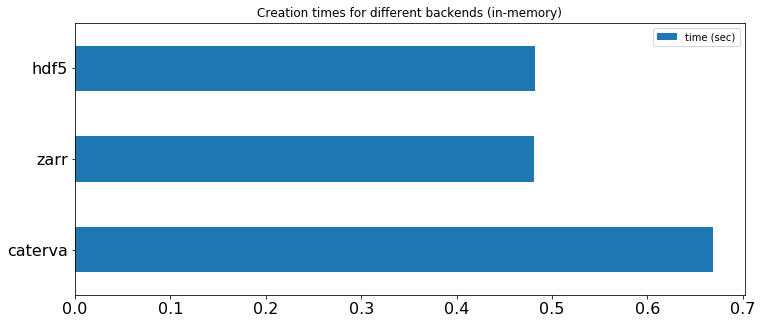

In [15]:
# Creation times
labels = ["caterva", "zarr", "hdf5"]
df = pd.DataFrame({'time (sec)': [wtimes['caterva'], wtimes['zarr'], wtimes['hdf5']]}, index=labels)
df.plot(kind='barh', figsize=(12,5), color=None, fontsize=fontsize, title="Creation times for different backends (%s)" % store)

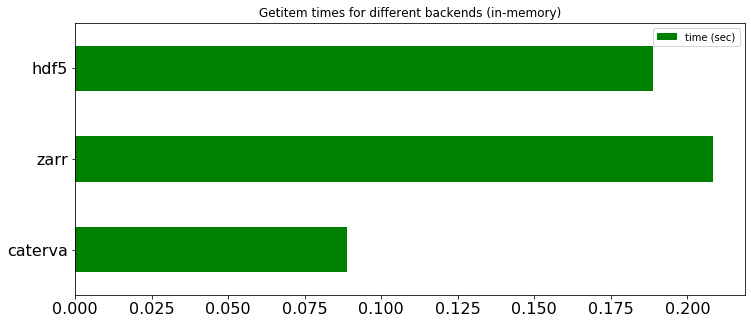

In [16]:
# Getitem times
labels = ["caterva", "zarr", "hdf5"]
df = pd.DataFrame({'time (sec)': [rtimes['caterva'], rtimes['zarr'], rtimes['hdf5']]}, index=labels)
df.plot(kind='barh', figsize=(12,5), color="green", fontsize=fontsize, title="Getitem times for different backends (%s)" % store)